> # **Introduction**

Perkenalkan nama saya **Verindra Hernanda Putra**, nah notebook ini merupakan notebook dengan dataset yang saya ambil dari Kaggle yaitu "**car data**", dengan harapan dataset ini bisa saya gunakan dengan baik dari **Week 1** sampai **Week 5** dalam kegiatan **Rekruitasi MBC Laboratory**

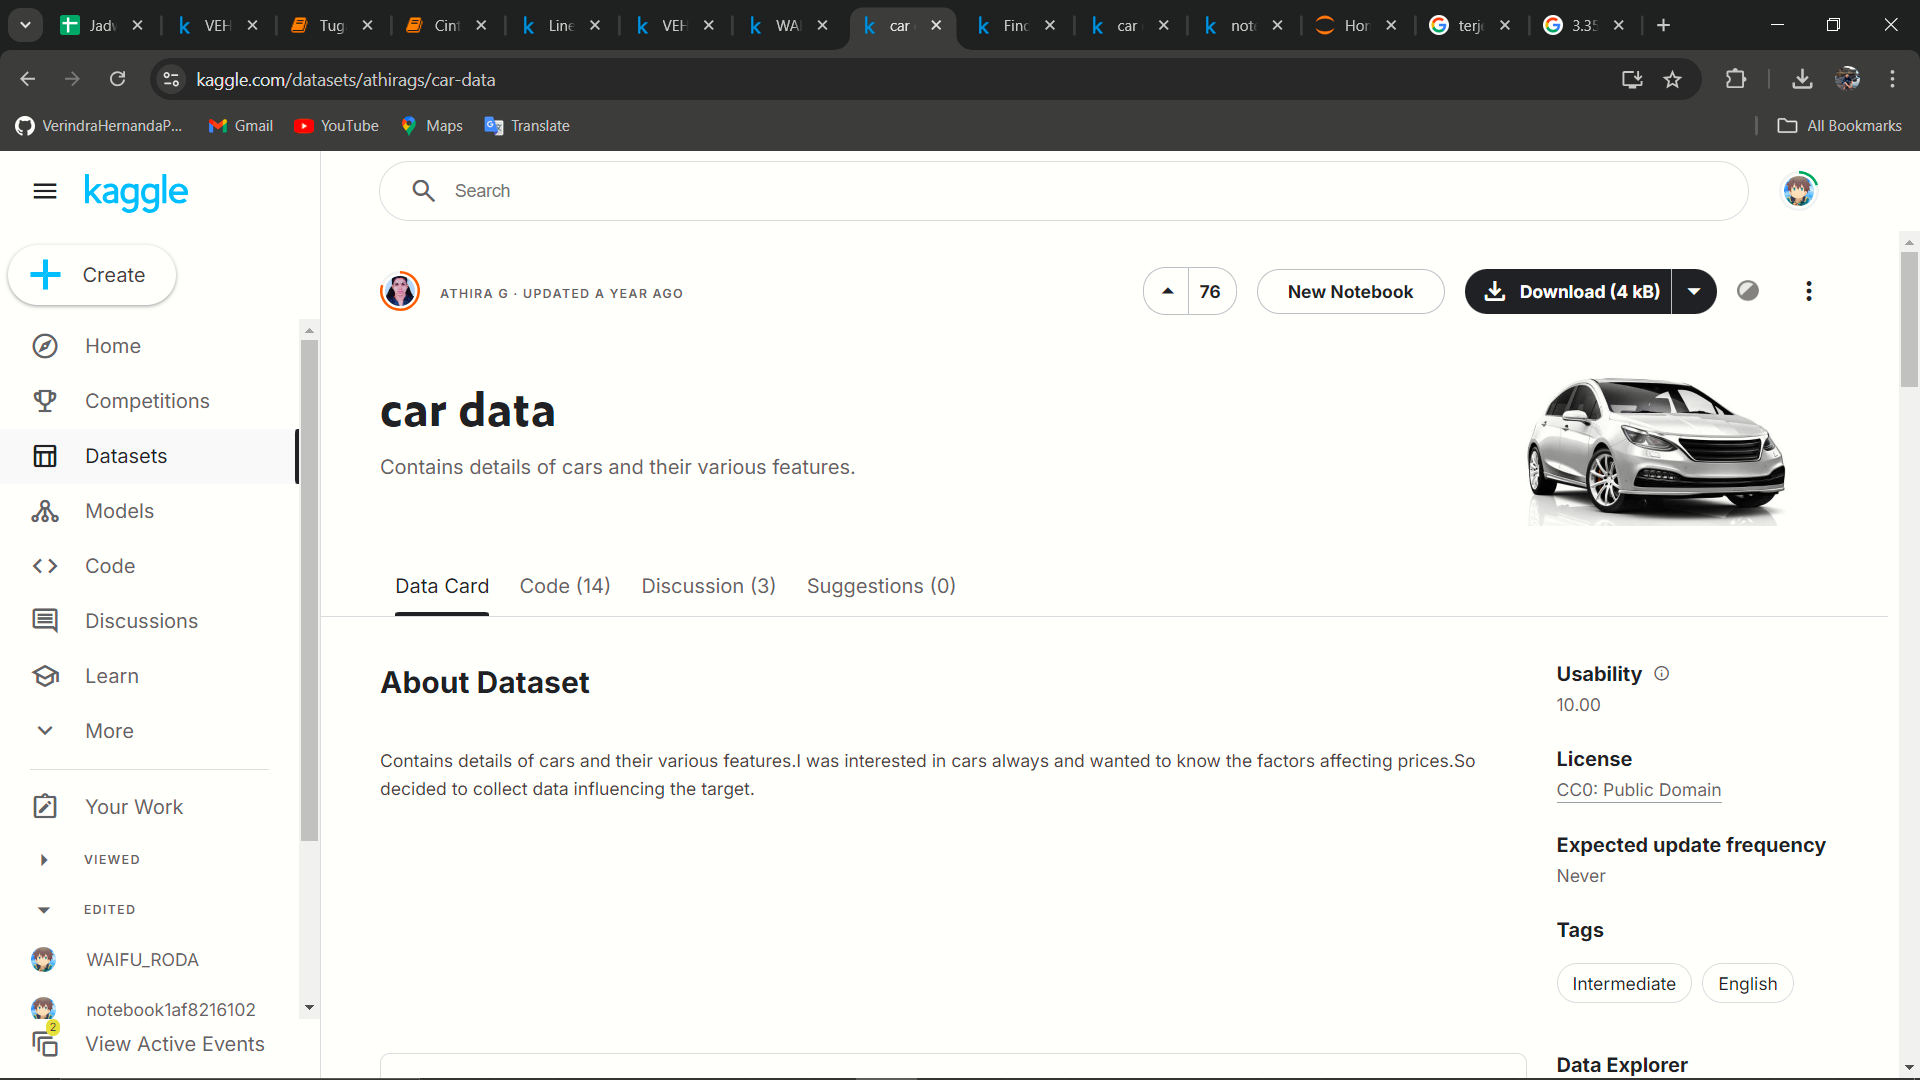

Jadi dataset ini merupakan dataset yang Berisi detail mobil dan berbagai fiturnya. Tujuan dibuatnya dataset ini karena pembuatnya selalu tertarik dengan mobil dan ingin mengetahui faktor-faktor yang mempengaruhi harga. Jadi memutuskan untuk mengumpulkan data yang mempengaruhi target.

**TASK :** Regression Data - Prediksi Harga Jual Mobil

# ‚ú¶ **LIBRARY**

In [1]:
# CaAs_Verindra Hernanda Putra - 1303223055 - 2426

# Import Library

# Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Encoding
from sklearn.preprocessing import LabelEncoder

# Split
from sklearn.model_selection import train_test_split

# Scaler
from sklearn.preprocessing import StandardScaler

# Optimisasi
from sklearn.model_selection import RandomizedSearchCV

# Model
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor

# Evaluation
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_absolute_error as MAE

# ‚ú¶ **FUNGSI**

In [2]:
# Buat Boxplot semua kolom
def create_boxplots(df):

  # Pilih Kolom Numerikal
  numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

  # Hitung dimensi figure
  num_subplots = len(numeric_cols)
  nrows = int(np.sqrt(num_subplots))
  ncols = int(np.ceil(num_subplots / nrows))

  # Buat figure
  plt.figure(figsize=(15, 10))

  # Buat subplots dan boxplots
  for i, col in enumerate(numeric_cols):
    plt.subplot(nrows, ncols, i+1)
    sns.boxplot(x=df[col])
    plt.title(col)

  plt.tight_layout()
  plt.show()
    
# Deteksi Outlier
def deteksi_outlier(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    batas_bawah = Q1 - 1.5 * IQR
    batas_atas = Q3 + 1.5 * IQR
    
    return data[(data[column] < batas_bawah) | (data[column] > batas_atas)]

# RMSE
def RMSE(Y_train_true, Y_train_pred):
  MSe = MSE(Y_train_true, Y_train_pred)
  RMSE = np.sqrt(MSe)
  return RMSE

# Hitung nilai_cap
def nilai_cap(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1

  cap_value = Q3 + 1.5 * IQR

  return cap_value

# Hitung nilai_floor
def nilai_floor(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1

  floor_value = Q1 - 1.5 * IQR

  return floor_value

# Cap/Floor
def cap_floor(df, column):
  floor = nilai_floor(df, column)
  cap = nilai_cap(df, column)
  df[column] = df[column].clip(lower=floor, upper=cap)

  return df

# Cap/Floor All
def cap_floor_all_columns(df):

  for col in df.select_dtypes(include=['float64']).columns:
    floor = nilai_floor(df, col)
    cap = nilai_cap(df, col)
    df = cap_floor(df, col)

  return df

def scores_df(Y_test, Y_train, Y_pred_test, Y_pred_train):
    result = pd.DataFrame({'Matrix': ['MAE', 'MSE', 'RMSE', 'R2'],
                           'Train': [MAE(Y_train, Y_pred_train), 
                                    MSE(Y_train, Y_pred_train), 
                                    RMSE(Y_train, Y_pred_train),
                                    R2(Y_train, Y_pred_train)],
                           
                           'Test': [MAE(Y_test, Y_pred_test), 
                                    MSE(Y_test, Y_pred_test), 
                                    RMSE(Y_test, Y_pred_test),
                                    R2(Y_test, Y_pred_test)]})
    result.set_index('Matrix', inplace=True)
    
    return result

# ‚ú¶ **TENTANG DATASET**

In [3]:
# Panggil Dataset
df = pd.read_csv("D:/OPREC_MBC/IMPROVISASI/Dataset/cardata.csv")

In [4]:
# Tampilkan tabel
df

Car_Name  Year  Selling_Price  Present_Price  Kms_Driven Fuel_Type  \
0       ritz  2014           3.35           5.59       27000    Petrol   
1        sx4  2013           4.75           9.54       43000    Diesel   
2       ciaz  2017           7.25           9.85        6900    Petrol   
3    wagon r  2011           2.85           4.15        5200    Petrol   
4      swift  2014           4.60           6.87       42450    Diesel   
..       ...   ...            ...            ...         ...       ...   
296     city  2016           9.50          11.60       33988    Diesel   
297     brio  2015           4.00           5.90       60000    Petrol   
298     city  2009           3.35          11.00       87934    Petrol   
299     city  2017          11.50          12.50        9000    Diesel   
300     brio  2016           5.30           5.90        5464    Petrol   

    Seller_Type Transmission  Owner  
0        Dealer       Manual      0  
1        Dealer       Manual      0  
2        Dealer       Manual      0  
3        Dealer       Manual      0  
4        Dealer       Manual      0  
..          ...          ...    ...  
296      Dealer       Manual      0  
297      Dealer       Manual      0  
298      Dealer       Manual      0  
299      Dealer       Manual      0  
300      Dealer       Manual      0  

[301 rows x 9 columns]

**Analisis Dataset**

Data-data kolom yang ada dalam dataset ini adalah : 
* **Car_Name :** Nama mobil
* **Year :** Tahun mobil dibuat
* **Selling_Price :** Harga Mobil saat ini **- Target**
* **Present_Price :** Harga Mobil Original
* **Kms_Driven :** Jumlah Kilometer yang dikendarai mobil
* **Fuel_Type :** Tipe bensin
* **Seller_Type :** Penjual adalah Individu atau Dealer
* **Transmission :** Transmisi mobil (Otomatis/Manual)
* **Owner :** Jumlah pemilik mobil sebelumnya

**Total Kolom = 9 | Total Baris = 301**



**GOALS**

Baik disini itu merupakan dataset yang bertujuan untuk memprediksi harga mobil sekarang dari mobil berdasarkan data-data yang ada

*   **Fitur Target :** Selling_Price
*   **Model :** Regresi

# **‚û• DATA CLEANING**

## ‚ô¢ **DROP IRRELEVANT COLUMNS**

Pertama-tama, kita akan menghapus kolom yang tidak relevan terlebih dahulu. Disini salah satu kolom yang saya hapus adalah nama mobil dikarenakan kolom tersebut tidak memberikan informasi yang berharga untuk proses modelling kitaa

In [5]:
# Hapus Data yang tidak relevan dengan target
df = df.drop(columns='Car_Name', axis=1)

In [6]:
df.sample()

Year  Selling_Price  Present_Price  Kms_Driven Fuel_Type Seller_Type  \
238  2013            4.8            9.4       60241    Petrol      Dealer   

    Transmission  Owner  
238       Manual      0

## ‚ô¢ **HANDLING DUPLICATION**

Atasi nilai duplikat yang terdeteksi pada dataset

In [7]:
# Cek Duplikasi
df.duplicated().sum()

np.int64(2)

In [8]:
# Hapus Duplikat
df.drop_duplicates(inplace=True)

## ‚ô¢ **HANDLING MISSING VALUES**

Atasi missing values yang terdeteksi pada dataset

In [9]:
missing_values = df.isnull().sum()

# Hitung Presentase Missing Values
presentase_missing = (df.isnull().sum() / len(df)) * 100

# Tampilkan Hasil Missing Values
missing_info = pd.DataFrame({'Missing Values': missing_values, 'Presentase': presentase_missing})
print(missing_info)

               Missing Values  Presentase
Year                        0         0.0
Selling_Price               0         0.0
Present_Price               0         0.0
Kms_Driven                  0         0.0
Fuel_Type                   0         0.0
Seller_Type                 0         0.0
Transmission                0         0.0
Owner                       0         0.0


**DATASET AMAN DARI NULL VALUES** ‚úîÔ∏è

## ‚ô¢ **CHECK DATA TYPE**

Cek sekilas tipe-tipe variabel yang terkandung dalam dataset


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299 entries, 0 to 300
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           299 non-null    int64  
 1   Selling_Price  299 non-null    float64
 2   Present_Price  299 non-null    float64
 3   Kms_Driven     299 non-null    int64  
 4   Fuel_Type      299 non-null    object 
 5   Seller_Type    299 non-null    object 
 6   Transmission   299 non-null    object 
 7   Owner          299 non-null    int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 21.0+ KB


In [11]:
# List Kolom Numerikal
kolom_numerikal = ['Year', 'Selling_Price', 'Present_Price', 'Kms_Driven', 'Owner']

# List Kolom Kategorikal (Object)
kolom_kategorikal = ['Fuel_Type', 'Seller_Type', 'Transmission']

**ANALISIS** üïµ

Jika dilihat, ternyata beberapa data terdeteksi sebagai kategorikal dan numerikal yang dimana hal ini akan menjadi informasi penting untuk langkah-langkah yang kita bisa lakukan pada tahap preprocessing

## ‚ô¢ **HANDLING OUTLIERS**

Kita atasi Outlier yang terdeteksi terlebih dahulu

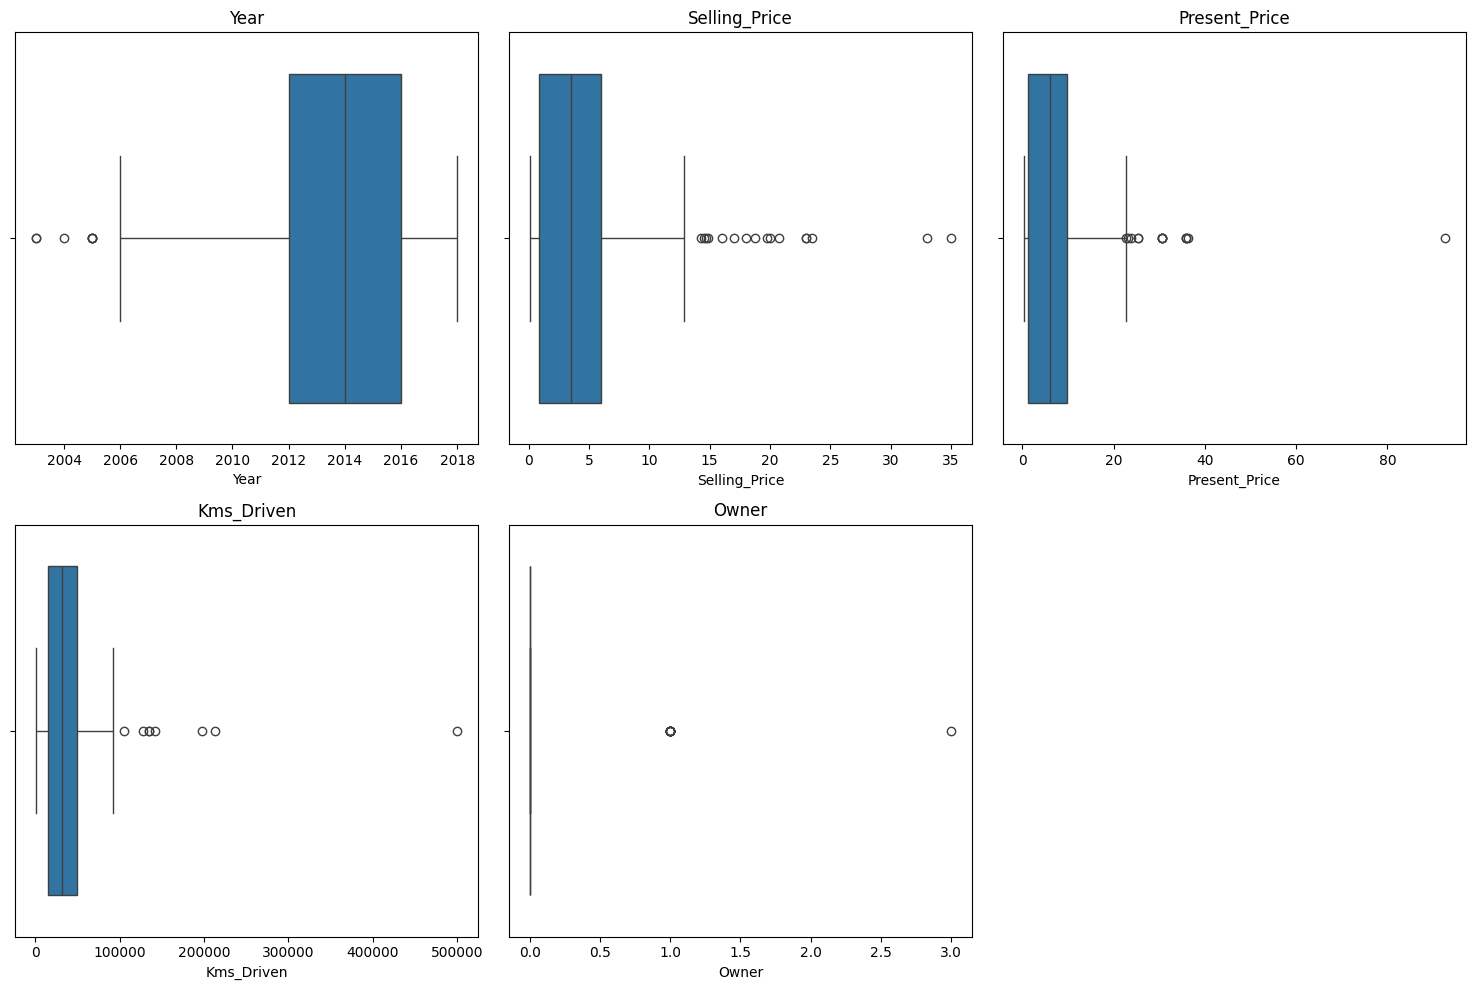

In [12]:
create_boxplots(df)

In [13]:
# Tampilkan
print("Jumlah Outlier pada semua kolom numerikal")
for column in kolom_numerikal:
    outliers = deteksi_outlier(df, column)
    print(f"{column}: {outliers.shape[0]}")

Jumlah Outlier pada semua kolom numerikal
Year: 7
Selling_Price: 16
Present_Price: 14
Kms_Driven: 8
Owner: 11


Disini terdeteksi beberapa outlier pada kolom numerikal, kita tidak bisa mengabaikannya karena outlier sangat berdampak signifikan pada perfomansi model yang akan dibuat

**ATASI OUTLIER PADA FITUR TARGET**

Pertama-tama kita akan fokus ke fitur target yaitu age

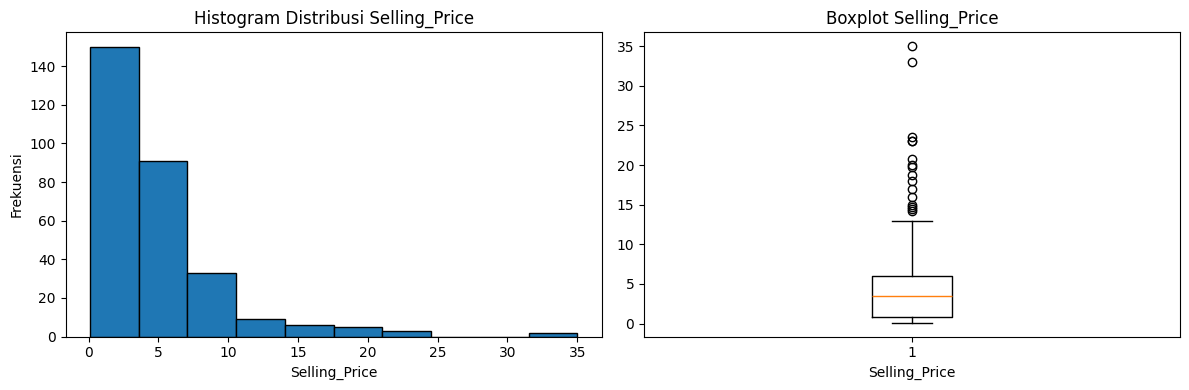

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['Selling_Price'], edgecolor='black')
plt.xlabel('Selling_Price')
plt.ylabel('Frekuensi')
plt.title('Histogram Distribusi Selling_Price')

plt.subplot(1, 2, 2)
plt.boxplot(df['Selling_Price'])
plt.xlabel('Selling_Price')
plt.ylabel('')
plt.title('Boxplot Selling_Price')

plt.tight_layout()
plt.show()

**ANALISIS** üïµ

Ada beberapa proses handling outlier yang bisa kita gunakan, yaitu :

- Menghapus Outlier
- Transform data (Ubah Skala Data)
- Cap/Floor (Pembatasan Nilai)
- Imputation (Mengganti Nilai)

Jika dilihat, ternyata kolom target distribusi targetnya sangat miring sekali dan terdapat beberapa outlier yang jauh maka kita akan batasi outlier yang jauh terlebih dahulu kemudian lakukan log transformation

In [15]:
# Batasi Outlier
df = df[(df['Selling_Price'] < 25)]

In [16]:
# Log Transformation
df["Selling_Price"] = np.log(1 + df["Selling_Price"])

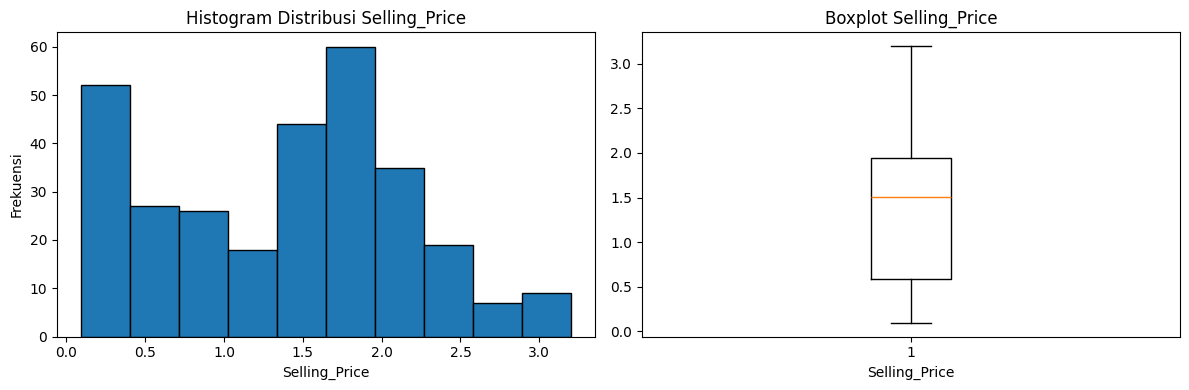

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['Selling_Price'], edgecolor='black')
plt.xlabel('Selling_Price')
plt.ylabel('Frekuensi')
plt.title('Histogram Distribusi Selling_Price')

plt.subplot(1, 2, 2)
plt.boxplot(df['Selling_Price'])
plt.xlabel('Selling_Price')
plt.ylabel('')
plt.title('Boxplot Selling_Price')

plt.tight_layout()
plt.show()

**ATASI OUTLIER PADA FITUR LAINNYA**

Selanjutnya adalah menangani outlier pada fitur-fitur selain target

1. Kms_driven : Hilangkan outlier yang jauh diantara outlier lainnya
2. Present_Price : Lakukan Log Transformation

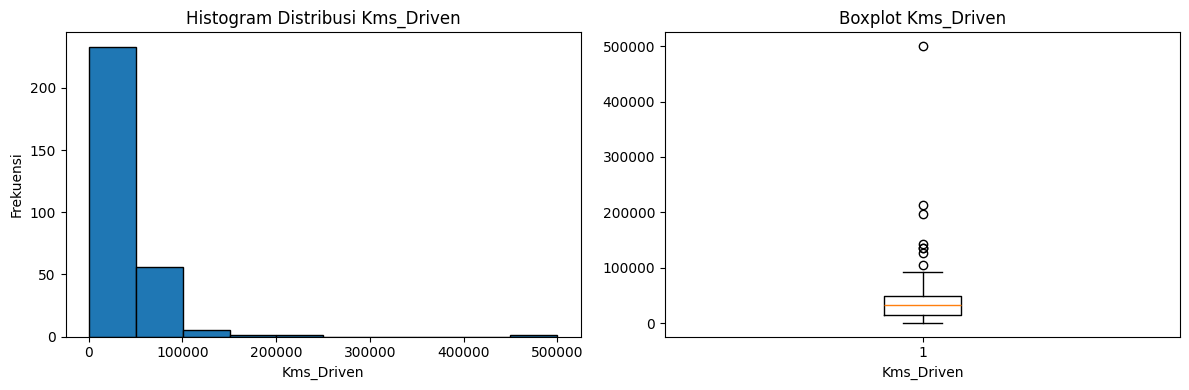

In [18]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['Kms_Driven'], edgecolor='black')
plt.xlabel('Kms_Driven')
plt.ylabel('Frekuensi')
plt.title('Histogram Distribusi Kms_Driven')

plt.subplot(1, 2, 2)
plt.boxplot(df['Kms_Driven'])
plt.xlabel('Kms_Driven')
plt.ylabel('')
plt.title('Boxplot Kms_Driven')

plt.tight_layout()
plt.show()

In [19]:
df = df[(df['Kms_Driven'] < 300000)]

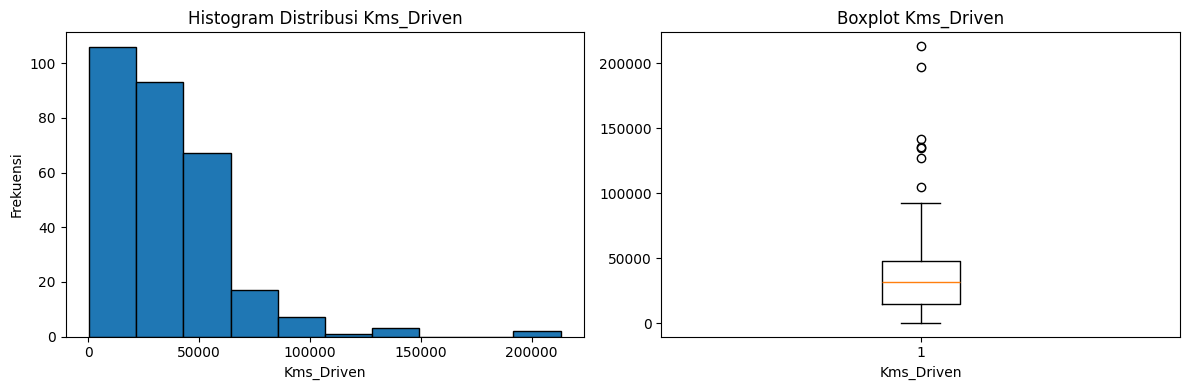

In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['Kms_Driven'], edgecolor='black')
plt.xlabel('Kms_Driven')
plt.ylabel('Frekuensi')
plt.title('Histogram Distribusi Kms_Driven')

plt.subplot(1, 2, 2)
plt.boxplot(df['Kms_Driven'])
plt.xlabel('Kms_Driven')
plt.ylabel('')
plt.title('Boxplot Kms_Driven')

plt.tight_layout()
plt.show()

In [21]:
# Log Transformation
df["Present_Price"] = np.log(1 + df["Present_Price"])

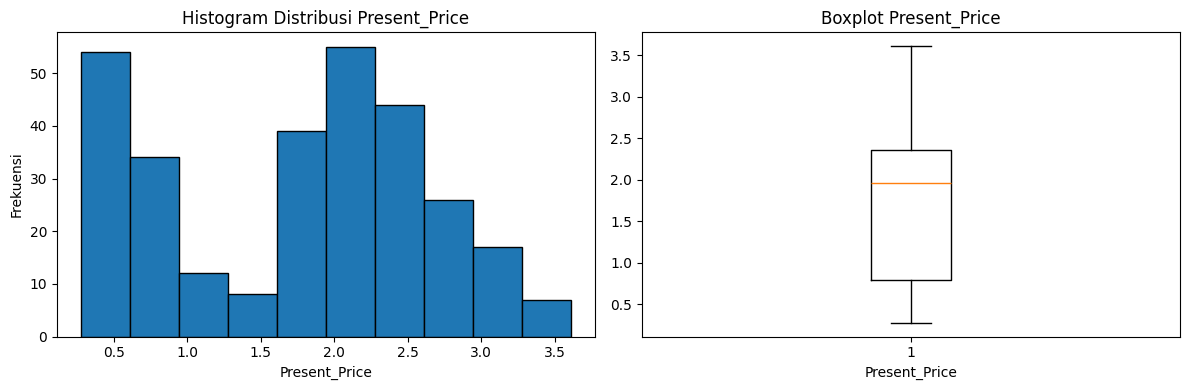

In [22]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['Present_Price'], edgecolor='black')
plt.xlabel('Present_Price')
plt.ylabel('Frekuensi')
plt.title('Histogram Distribusi Present_Price')

plt.subplot(1, 2, 2)
plt.boxplot(df['Present_Price'])
plt.xlabel('Present_Price')
plt.ylabel('')
plt.title('Boxplot Present_Price')

plt.tight_layout()
plt.show()

# **‚û• DATA PREPROCESSING**

**Heatmap pada kolom numerik**

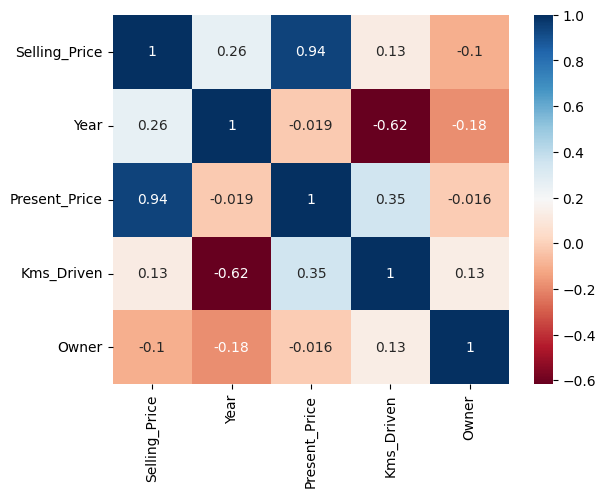

In [23]:
# Heatmap
num = df[['Selling_Price', 'Year', 'Present_Price', 'Kms_Driven', 'Owner']]

sns.heatmap(num.corr(), annot=True, cmap="RdBu")
plt.show()

## ‚ô¢ **FEATURE ENGINEERING**

Lakukan beberapa feature engineering pada kolom

Disini saya akan melakukan beberapa feature engineering yaitu :

1. Ganti beberapa nama kolom agar tidak terjadi kesalahpahaman antara fitur yang ada ['Present_Price'->'Harga_Original' dan'Selling_Price' -> 'Harga_Sekarang']

2. Ubah Kolom Tahun Menjadi Umur Mobil

3. Buat kolom baru "Mobil Bekas (Yes or No) dari kolom Car_Owner

> **GANTI NAMA KOLOM UNTUK HINDARI MISUNDERSTANDING ANTARA FITUR**

In [24]:
# Mengganti nama kolom Price
df = df.rename(columns={'Present_Price': 'Harga_Original', 'Selling_Price': 'Harga_Sekarang'})

In [25]:
df.sample()

Year  Harga_Sekarang  Harga_Original  Kms_Driven Fuel_Type Seller_Type  \
132  2017        0.559616        0.667829        3500    Petrol  Individual   

    Transmission  Owner  
132       Manual      0

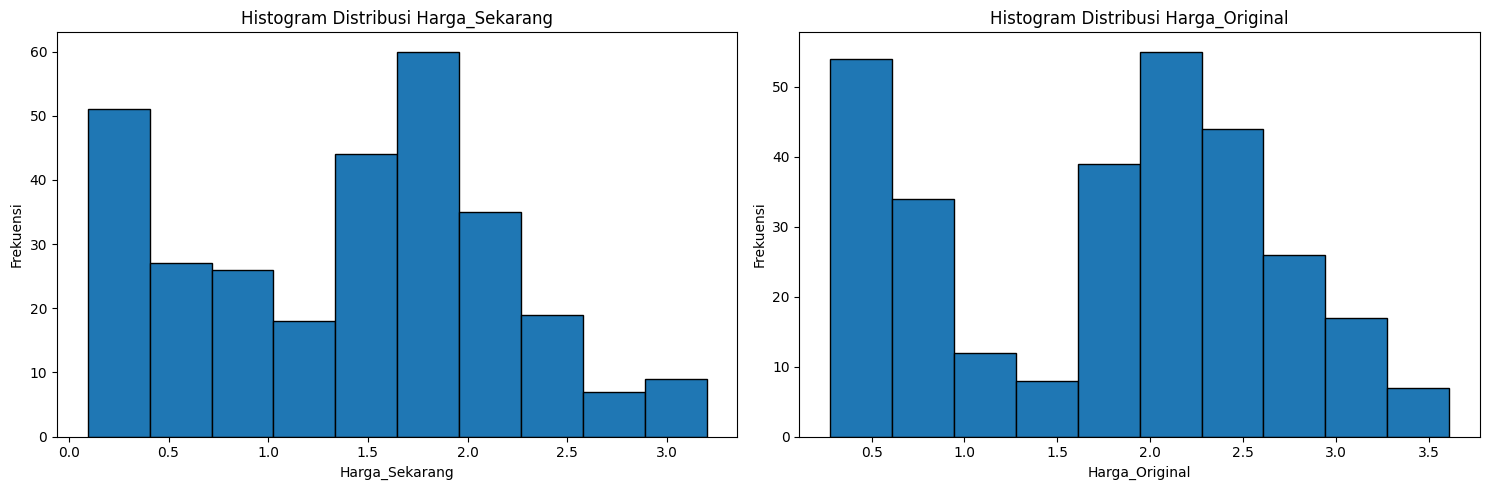

In [26]:
# Membuat figure dan axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Membuat histogram untuk setiap kolom
for i, col in enumerate(['Harga_Sekarang', 'Harga_Original']):
    axes[i].hist(df[col], edgecolor='black')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frekuensi')
    axes[i].set_title(f'Histogram Distribusi {col}')

# Menyesuaikan layout
plt.tight_layout()
plt.show()

In [27]:
# Statistik Deskriptif
df.describe()

Year  Harga_Sekarang  Harga_Original     Kms_Driven       Owner
count   296.000000      296.000000      296.000000     296.000000  296.000000
mean   2013.635135        1.393226        1.752401   35317.935811    0.043919
std       2.878674        0.780901        0.877596   28270.142107    0.249943
min    2003.000000        0.095310        0.277632     500.000000    0.000000
25%    2012.000000        0.628337        0.788457   15000.000000    0.000000
50%    2014.000000        1.505187        1.956561   31802.000000    0.000000
75%    2016.000000        1.940534        2.361963   48191.750000    0.000000
max    2018.000000        3.198673        3.609836  213000.000000    3.000000

> **Ubah Kolom Tahun Menjadi Umur Mobil**

In [28]:
# Ubah Data Tahun menjadi Umur Mobil
Age = []
i = 0

for i in df['Year']:
    Age.append(2024-i)

# Tambah Kolom Baru
df.insert(0, 'Car_Age', Age)

# Hapus Kolom
df = df.drop(columns='Year', axis=1)

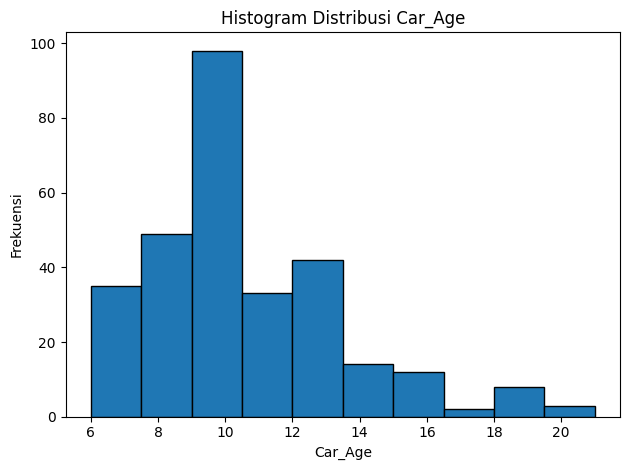

In [29]:
plt.hist(df['Car_Age'], edgecolor='black')
plt.xlabel('Car_Age')
plt.ylabel('Frekuensi')
plt.title(f'Histogram Distribusi Car_Age')

plt.tight_layout()
plt.show()

In [30]:
df.sample(5)

Car_Age  Harga_Sekarang  Harga_Original  Kms_Driven Fuel_Type  \
208        7        2.186051        2.208274        3435    Petrol   
77        20        0.916291        2.591516      135154    Petrol   
230       11        1.967112        2.341806       45000    Diesel   
161       10        0.371564        0.602128       23000    Petrol   
198       13        0.139762        0.451076       35000    Petrol   

    Seller_Type Transmission  Owner  
208      Dealer       Manual      0  
77       Dealer    Automatic      0  
230      Dealer       Manual      0  
161  Individual       Manual      0  
198  Individual       Manual      1

> **Buat kolom baru "Mobil Bekas"**

In [31]:
# Membuat kolom baru 'Status_Mobil'
df['Mobil Bekas'] = df['Owner'].apply(lambda x: 'No' if x == 0 else 'Yes')

# Hapus Kolom
df = df.drop(columns='Owner', axis=1)

In [32]:
df.sample(5)

Car_Age  Harga_Sekarang  Harga_Original  Kms_Driven Fuel_Type  \
150       13        0.405465        0.602128        6000    Petrol   
163       14        0.371564        0.667829       27000    Petrol   
55        15        1.526056        2.775086       70000    Petrol   
75         9        1.599388        2.054124       36000    Petrol   
28        14        1.081805        1.599388       44542    Petrol   

    Seller_Type Transmission Mobil Bekas  
150  Individual       Manual          No  
163  Individual       Manual          No  
55       Dealer    Automatic          No  
75       Dealer       Manual          No  
28       Dealer       Manual          No

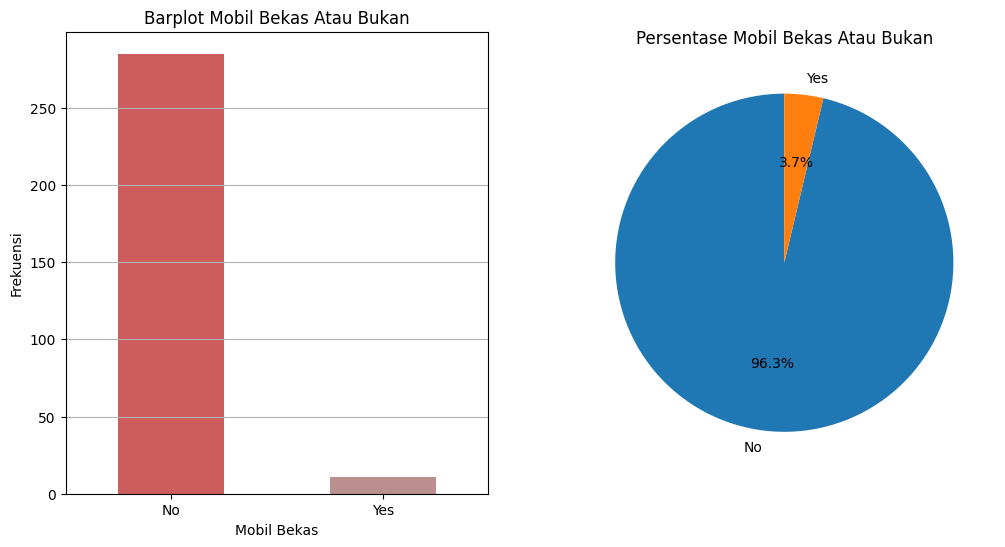

In [33]:
# Hitung
tipe1 = df[(df['Mobil Bekas'] == 'No')].shape[0]
tipe2 = df[(df['Mobil Bekas'] == 'Yes')].shape[0]

# Hitung Jumlah fuel
jumlah = df['Mobil Bekas'].value_counts()

# Value Tertinggi
maksimal = jumlah.idxmax()

# Warna Paling tinggi
colors = ['rosybrown'] * len(jumlah)
colors[jumlah.index.get_loc(maksimal)] = 'indianred'

# Fig size
plt.figure(figsize=(12, 6))

# Bar plot
plt.subplot(1, 2, 1)
jumlah.plot(kind='bar', color=colors)
plt.title('Barplot Mobil Bekas Atau Bukan')
plt.ylabel('Frekuensi')
plt.grid(axis='y')
plt.xticks(rotation=0)

# Pie chart
plt.subplot(1, 2, 2)
plt.pie(jumlah, labels=jumlah.index, autopct='%1.1f%%', startangle=90)
plt.title('Persentase Mobil Bekas Atau Bukan')

plt.show()

In [34]:
import math

def create_bar_count_plots(df):

    # Pilih kolom kategorikal
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    # Hitung jumlah subplot
    num_subplots = len(categorical_cols)

    # Hitung jumlah baris dan kolom subplot
    num_cols = 2
    num_rows = math.ceil(num_subplots / num_cols)

    # Buat figure
    plt.figure(figsize=(12, num_rows * 3))

    # Buat subplot dan bar count plot
    for i, col in enumerate(categorical_cols):
        plt.subplot(num_rows, num_cols, i+1)
        sns.countplot(x=df[col])
        plt.title(col, fontweight='bold')
        plt.xticks(rotation=0)
        plt.grid(axis='y')

    # Atur layout dan tampilkan plot
    plt.tight_layout()
    plt.show()

**VISUALISASI PADA BEBERAPA KOLOM KATEGORIKAL**

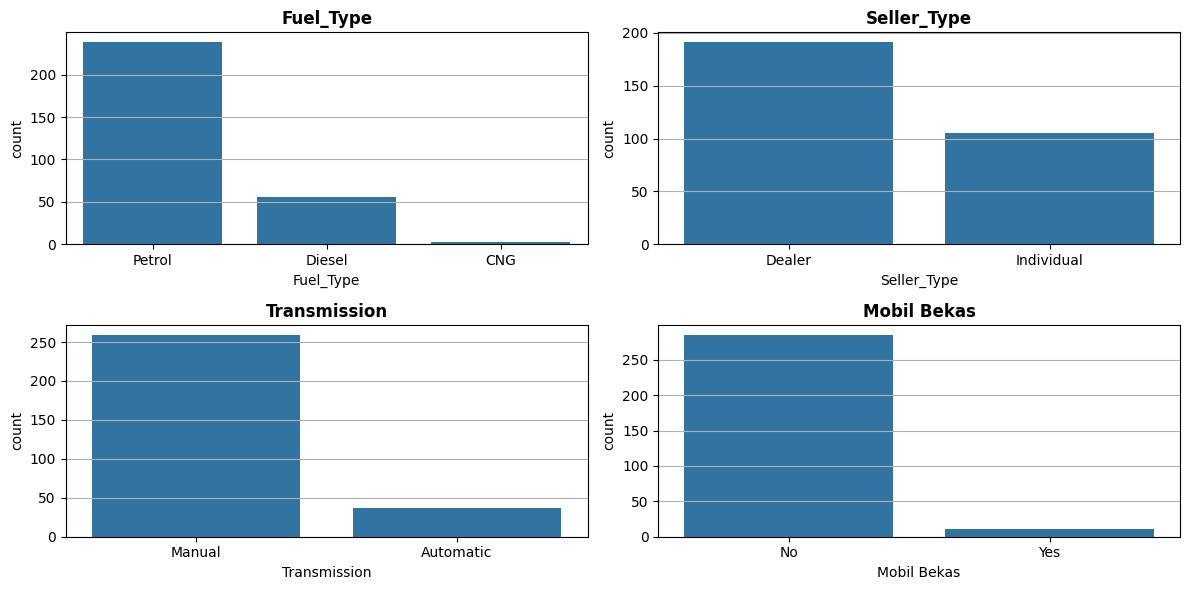

In [35]:
create_bar_count_plots(df)

## ‚ô¢ **ENCODING**

Lakukan encoding pada kolom kategorikal (object)

In [39]:
# Encoding Label
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['Fuel_Type'] = le.fit_transform(df['Fuel_Type'])
df['Seller_Type'] = le.fit_transform(df['Seller_Type'])
df['Transmission'] = le.fit_transform(df['Transmission'])
df['Mobil Bekas'] = le.fit_transform(df['Mobil Bekas'])

In [ ]:
df.head()

Car_Age  Harga_Sekarang  Harga_Original  Kms_Driven  Fuel_Type  \
0  2.302585        1.208960        1.720979   10.203592          2   
1  2.397895        1.558145        2.255493   10.668955          1   
2  1.945910        1.981001        2.287471    8.839277          2   
3  2.564949        1.047319        1.423108    8.556414          2   
4  2.302585        1.526056        1.927164   10.656082          1   

   Seller_Type  Transmission  Selisih_Harga  Mobil Bekas  
0            0             1       0.806476            0  
1            0             1       1.566530            0  
2            0             1       0.955511            0  
3            0             1       0.262364            0  
4            0             1       0.819780            0

## ‚ô¢ **KORELASI**

Cek Korelasi untuk mengecek relevansi fitur-fitur kolom yang ada dengan target

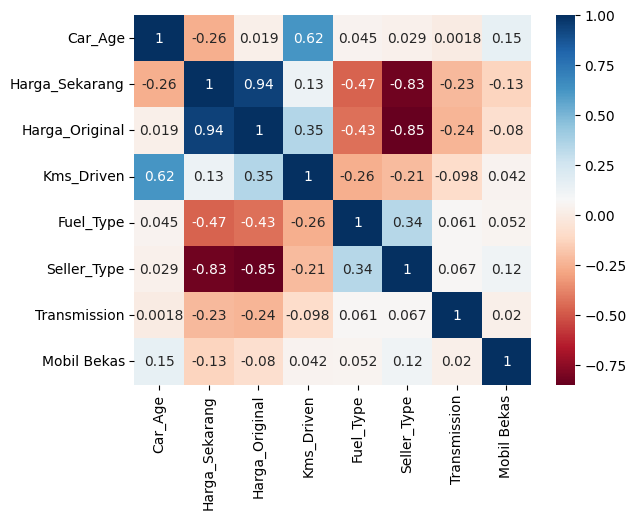

In [40]:
# Heatmap
sns.heatmap(df.corr(), annot=True, cmap="RdBu")
plt.show()

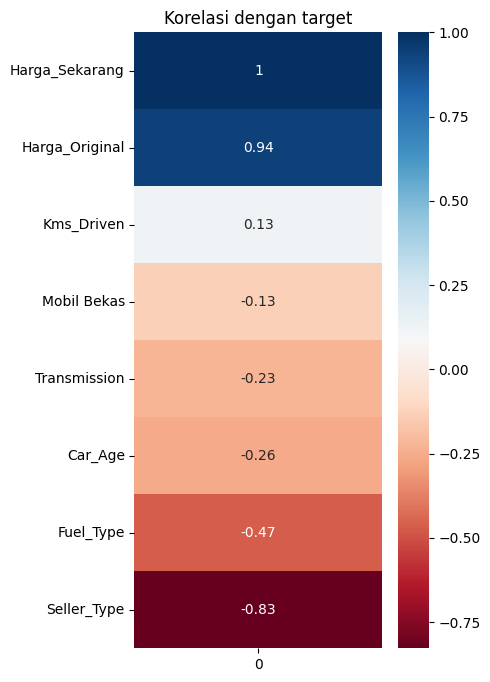

In [42]:
# Buat korelasi matrix target
corr_with_target = df.corrwith(df['Harga_Sekarang'])

# Sorting Fitur
corr_with_target = corr_with_target.sort_values(ascending=False)

# Heatmap
plt.figure(figsize=(4, 8))
sns.heatmap(corr_with_target.to_frame(), cmap='RdBu', annot=True)
plt.title('Korelasi dengan target')
plt.show()

**ANALISIS** üïµ

Jika dilihat Harga Original memiliki korelasi tertinggi dengan fitur target

# **‚û• MODELLING**

## ‚ô¢ **SPLITTING DATA**

In [43]:
# Pisahkan variabel fitur dengan variabel target
X = df.drop(columns = 'Harga_Sekarang', axis=1)
Y = df['Harga_Sekarang']

# Pisahkan data menjadi train dan test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [44]:
# Ubah ke Numpy Array
X_train = X_train.values
X_test = X_test.values

## ‚ô¢ **MODEL YANG AKAN DIGUNAKAN**

List Model yang akan saya gunakan adalah :
* Ridge Regression (Modifikasi dari Linear Regression)
* XGBRegression
* Random Forest
* Gradient Boosting
* Bagging Regressor

## ‚ô¢ **OPTIMISASI MODEL**

Disini saya akan melakukan optimisasi model dengan menggunakan random search untuk mendapatkan hyperparameter terbaik untuk dimasukkan pada setiap model machine learning yang akan saya gunakan

In [45]:
# Ridge (Modifikasi dari Linear Regression untuk cegah overfitting)
R = Ridge()
params_R = {
    'alpha': [0.1, 1.0, 10.0]
}

# XGBR
XGB = XGBRegressor()
params_XGB = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 5, 7, 9],
    'reg_alpha': [0, 0.1, 0.2],
    'reg_lambda': [0, 0.1, 0.2],
    'random_state': [42]
}

# Random Forest
RF = RandomForestRegressor()
params_RF = {
    'n_estimators': [100, 200, 500],
    'max_depth': [2, 5, 7, 9],
    'random_state': [42]
}

# Gradient Boosting
GB = GradientBoostingRegressor()
params_GB = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 5, 7, 9],
    'random_state': [42]
}

# Bagging Regressor
BR = BaggingRegressor()
params_BR = {
    'n_estimators': [100, 200, 500],
    'max_samples': [0.8, 0.9, 1.0],
    'max_features': [0.8, 0.9, 1.0],
    'random_state': [42]
}

# Random Search untuk mendapatkan best params
random_search_R = RandomizedSearchCV(estimator=R, param_distributions=params_R, n_iter=3, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search_XGB = RandomizedSearchCV(estimator=XGB, param_distributions=params_XGB, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search_RF = RandomizedSearchCV(estimator=RF, param_distributions=params_RF, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search_GB = RandomizedSearchCV(estimator=GB, param_distributions=params_GB, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search_BR = RandomizedSearchCV(estimator=BR, param_distributions=params_BR, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

## ‚ô¢ **TRAIN MODEL**

Disini kita akan melatih model kita berdasarkan hasil RandomSearch yang telah dilakukan

In [46]:
random_search_R.fit(X_train, Y_train)

RandomizedSearchCV(cv=5, estimator=Ridge(), n_iter=3,
                   param_distributions={'alpha': [0.1, 1.0, 10.0]},
                   random_state=42, scoring='neg_mean_squared_error')

In [48]:
random_search_XGB.fit(X_train, Y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [2, 5, 7, 9],
                                        'n_estimators': [50, 100, 200],
                                        'random_state': [42],
                                        'reg_alpha': [0, 0.1, 0.2],
                                        'reg_lambda': [0, 0.1, 0.2]},
                   random_state=42, scoring='neg_mean_squared_error')

In [50]:
random_search_RF.fit(X_train, Y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': [2, 5, 7, 9],
                                        'n_estimators': [100, 200, 500],
                                        'random_state': [42]},
                   random_state=42, scoring='neg_mean_squared_error')

In [52]:
random_search_GB.fit(X_train, Y_train)

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(),
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [2, 5, 7, 9],
                                        'n_estimators': [100, 200, 500],
                                        'random_state': [42]},
                   random_state=42, scoring='neg_mean_squared_error')

In [53]:
random_search_BR.fit(X_train, Y_train)

RandomizedSearchCV(cv=5, estimator=BaggingRegressor(),
                   param_distributions={'max_features': [0.8, 0.9, 1.0],
                                        'max_samples': [0.8, 0.9, 1.0],
                                        'n_estimators': [100, 200, 500],
                                        'random_state': [42]},
                   random_state=42, scoring='neg_mean_squared_error')

## ‚ô¢ **EVALUASI MODEL**

Berikut merupakan hasil evaluasi matrix dari semua model diatas

### ‚Ä¢ **Ridge Regression**

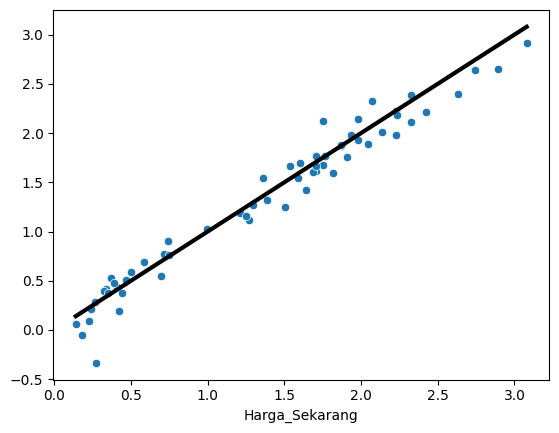

EVALUASI TEST
MAE: 0.11905070627518301
MSE: 0.024915810439008763
RMSE: 0.15784742772376356
R2: 0.9610730104269286

PERBANDINGAN TRAIN DAN TEST


Train      Test
Matrix                    
MAE     0.112521  0.119051
MSE     0.021746  0.024916
RMSE    0.147465  0.157847
R2      0.963718  0.961073

In [47]:
# Dapatkan Best Parameter
best_params_R = random_search_R.best_params_
best_model_R = random_search_R.best_estimator_

# Prediksi Model
Y_pred_train = best_model_R.predict(X_train)
Y_pred_test = best_model_R.predict(X_test)

# ScatterPlot
sns.scatterplot(x=Y_test, y=Y_pred_test)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k-', lw=3)
plt.show()

# Evaluasi
print('EVALUASI TEST')
print('MAE:', MAE(Y_test, Y_pred_test))
print('MSE:', MSE(Y_test, Y_pred_test))
print('RMSE:', RMSE(Y_test, Y_pred_test))
print('R2:', R2(Y_test, Y_pred_test))

# Perbandingan Test dan Train
print('\nPERBANDINGAN TRAIN DAN TEST')
scores_df(Y_test, Y_train, Y_pred_test, Y_pred_train)

### ‚Ä¢ **XGB Regressor** üåü

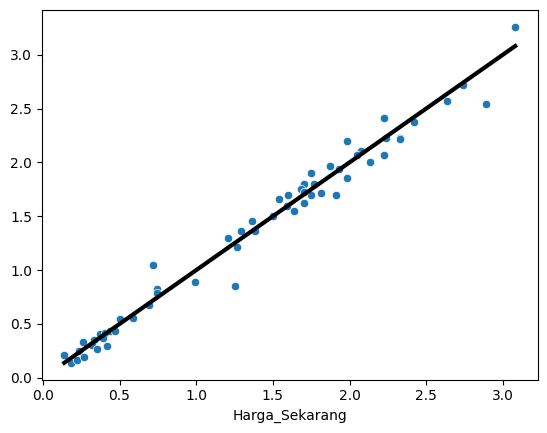

EVALUASI TEST
MAE: 0.08553424570278077
MSE: 0.01401229053077107
RMSE: 0.11837352124006056
R2: 0.9781080254755754

PERBANDINGAN TRAIN DAN TEST


Train      Test
Matrix                    
MAE     0.052497  0.085534
MSE     0.004218  0.014012
RMSE    0.064948  0.118374
R2      0.992962  0.978108

In [49]:
# Dapatkan Best Parameter
best_params_XGB = random_search_XGB.best_params_
best_model_XGB = random_search_XGB.best_estimator_

# Prediksi Model
Y_pred_train = best_model_XGB.predict(X_train)
Y_pred_test = best_model_XGB.predict(X_test)

# ScatterPlot
sns.scatterplot(x=Y_test, y=Y_pred_test)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k-', lw=3)
plt.show()

# Evaluasi
print('EVALUASI TEST')
print('MAE:', MAE(Y_test, Y_pred_test))
print('MSE:', MSE(Y_test, Y_pred_test))
print('RMSE:', RMSE(Y_test, Y_pred_test))
print('R2:', R2(Y_test, Y_pred_test))

# Perbandingan Test dan Train
print('\nPERBANDINGAN TRAIN DAN TEST')
scores_df(Y_test, Y_train, Y_pred_test, Y_pred_train)

### ‚Ä¢ **Random Forest Regressor**

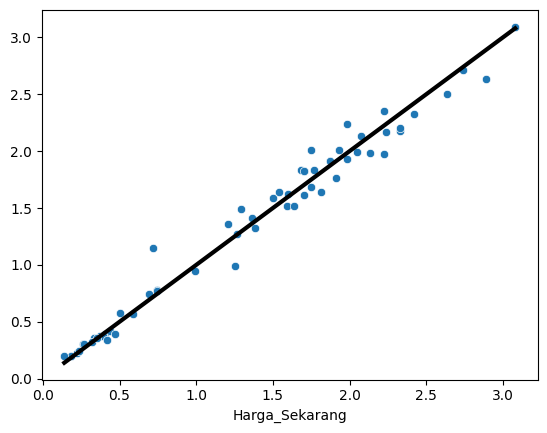

EVALUASI TEST
MAE: 0.08985342064038576
MSE: 0.015000102133997195
RMSE: 0.12247490409874667
R2: 0.9765647270116113

PERBANDINGAN TRAIN DAN TEST


Train      Test
Matrix                    
MAE     0.036777  0.089853
MSE     0.002776  0.015000
RMSE    0.052692  0.122475
R2      0.995368  0.976565

In [51]:
# Dapatkan Best Parameter
best_params_RF = random_search_RF.best_params_
best_model_RF = random_search_RF.best_estimator_

# Prediksi Model
Y_pred_train = best_model_RF.predict(X_train)
Y_pred_test = best_model_RF.predict(X_test)

# ScatterPlot
sns.scatterplot(x=Y_test, y=Y_pred_test)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k-', lw=3)
plt.show()

# Evaluasi
print('EVALUASI TEST')
print('MAE:', MAE(Y_test, Y_pred_test))
print('MSE:', MSE(Y_test, Y_pred_test))
print('RMSE:', RMSE(Y_test, Y_pred_test))
print('R2:', R2(Y_test, Y_pred_test))

# Perbandingan Test dan Train
print('\nPERBANDINGAN TRAIN DAN TEST')
scores_df(Y_test, Y_train, Y_pred_test, Y_pred_train)

### ‚Ä¢ **Gradient Boosting Regressor** 

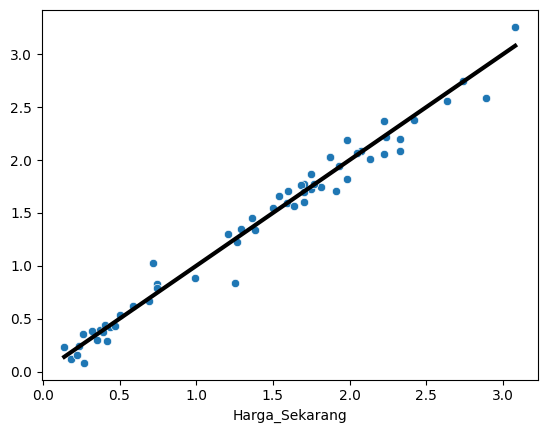

EVALUASI TEST
MAE: 0.09114750386088304
MSE: 0.01515312483091571
RMSE: 0.12309802935431464
R2: 0.9763256533944006

PERBANDINGAN TRAIN DAN TEST


Train      Test
Matrix                    
MAE     0.045396  0.091148
MSE     0.003054  0.015153
RMSE    0.055266  0.123098
R2      0.994904  0.976326

In [54]:
# Dapatkan Best Parameter
best_params_GB = random_search_GB.best_params_
best_model_GB = random_search_GB.best_estimator_

# Prediksi Model
Y_pred_train = best_model_GB.predict(X_train)
Y_pred_test = best_model_GB.predict(X_test)

# ScatterPlot
sns.scatterplot(x=Y_test, y=Y_pred_test)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k-', lw=3)
plt.show()

# Evaluasi
print('EVALUASI TEST')
print('MAE:', MAE(Y_test, Y_pred_test))
print('MSE:', MSE(Y_test, Y_pred_test))
print('RMSE:', RMSE(Y_test, Y_pred_test))
print('R2:', R2(Y_test, Y_pred_test))

# Perbandingan Test dan Train
print('\nPERBANDINGAN TRAIN DAN TEST')
scores_df(Y_test, Y_train, Y_pred_test, Y_pred_train)

### ‚Ä¢ **Bagging Regressor**

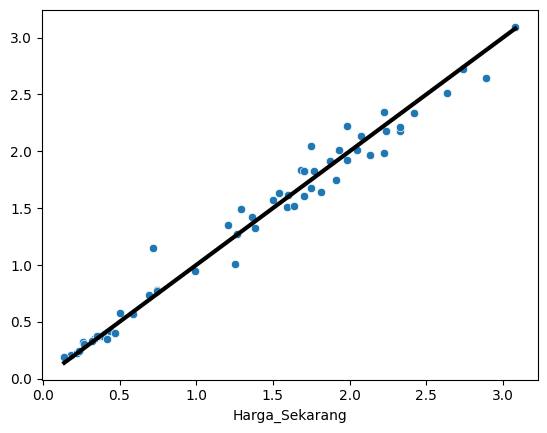

EVALUASI TEST
MAE: 0.0886797289656966
MSE: 0.01481705215563104
RMSE: 0.12172531435831678
R2: 0.9768507134785839

PERBANDINGAN TRAIN DAN TEST


Train      Test
Matrix                    
MAE     0.034731  0.088680
MSE     0.002589  0.014817
RMSE    0.050880  0.121725
R2      0.995681  0.976851

In [55]:
# Dapatkan Best Parameter
best_params_BR = random_search_BR.best_params_
best_model_BR = random_search_BR.best_estimator_

# Prediksi Model
Y_pred_train = best_model_BR.predict(X_train)
Y_pred_test = best_model_BR.predict(X_test)

# ScatterPlot
sns.scatterplot(x=Y_test, y=Y_pred_test)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k-', lw=3)
plt.show()

# Evaluasi
print('EVALUASI TEST')
print('MAE:', MAE(Y_test, Y_pred_test))
print('MSE:', MSE(Y_test, Y_pred_test))
print('RMSE:', RMSE(Y_test, Y_pred_test))
print('R2:', R2(Y_test, Y_pred_test))

# Perbandingan Test dan Train
print('\nPERBANDINGAN TRAIN DAN TEST')
scores_df(Y_test, Y_train, Y_pred_test, Y_pred_train)

## ‚ô¢ **EVALUASI AKHIR**

Berdasarkan semua hasil model yang telah dilakukan, maka setelah dilakukan semua percobaan dan analisis. Disini saya akhirnya memutuskan untuk menggunakan model dengan nilai terbaik yaitu ada pada

* XGB Regressor

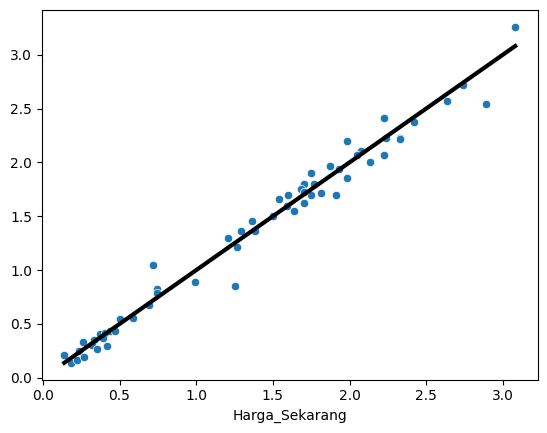

EVALUASI TEST
MAE: 0.08553424570278077
MSE: 0.01401229053077107
RMSE: 0.11837352124006056
R2: 0.9781080254755754

PERBANDINGAN TRAIN DAN TEST


Train      Test
Matrix                    
MAE     0.052497  0.085534
MSE     0.004218  0.014012
RMSE    0.064948  0.118374
R2      0.992962  0.978108

In [56]:
# Dapatkan Best Parameter
best_params_XGB = random_search_XGB.best_params_
best_model_XGB = random_search_XGB.best_estimator_

# Prediksi Model
Y_pred_train = best_model_XGB.predict(X_train)
Y_pred_test = best_model_XGB.predict(X_test)

# ScatterPlot
sns.scatterplot(x=Y_test, y=Y_pred_test)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k-', lw=3)
plt.show()

# Evaluasi
print('EVALUASI TEST')
print('MAE:', MAE(Y_test, Y_pred_test))
print('MSE:', MSE(Y_test, Y_pred_test))
print('RMSE:', RMSE(Y_test, Y_pred_test))
print('R2:', R2(Y_test, Y_pred_test))

# Perbandingan Test dan Train
print('\nPERBANDINGAN TRAIN DAN TEST')
scores_df(Y_test, Y_train, Y_pred_test, Y_pred_train)

# **‚û• PIPELINE**

Disini kita akan membuat sebuah pipeline berdasarkan hasil evaluasi model kita

In [67]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(best_model_XGB)

In [68]:
import pickle

with open("carprice.pkl", "wb") as model_file:
    pickle.dump(best_model_XGB, model_file)

In [69]:
df.head()

Car_Age  Harga_Sekarang  Harga_Original  Kms_Driven  Fuel_Type  \
0       10        1.470176        1.885553       27000          2   
1       11        1.749200        2.355178       43000          1   
2        7        2.110213        2.384165        6900          2   
3       13        1.348073        1.638997        5200          2   
4       10        1.722767        2.063058       42450          1   

   Seller_Type  Transmission  Mobil Bekas  
0            0             1            0  
1            0             1            0  
2            0             1            0  
3            0             1            0  
4            0             1            0

In [70]:
# Inference Data
new_data = [10, 1.885553, 27000, 2, 0, 1, 0]

best_model_XGB.predict([new_data])

array([1.5102997], dtype=float32)

In [71]:
import pickle

with open("carprice.pkl", "rb") as model_file:
    model = pickle.load(model_file)

In [72]:
df.head()

Car_Age  Harga_Sekarang  Harga_Original  Kms_Driven  Fuel_Type  \
0       10        1.470176        1.885553       27000          2   
1       11        1.749200        2.355178       43000          1   
2        7        2.110213        2.384165        6900          2   
3       13        1.348073        1.638997        5200          2   
4       10        1.722767        2.063058       42450          1   

   Seller_Type  Transmission  Mobil Bekas  
0            0             1            0  
1            0             1            0  
2            0             1            0  
3            0             1            0  
4            0             1            0

In [73]:
# Assuming you have a DataFrame named 'df'
df.to_csv('Dataset_Final/cardata_modified.csv', index=False)

In [74]:
# Inference Data
new_data = [10, 1.885553, 27000, 2, 0, 1, 0]

hasil = model.predict([new_data])
hasil

array([1.5102997], dtype=float32)

In [76]:
# Ubah kembali log transformasi ke skala semula
hasil_asli = np.exp(hasil)
hasil_asli

array([4.5280876], dtype=float32)